In [1]:
import pandas as pd

data = pd.read_csv("../data/design-seeds.csv")

In [2]:
data

,image_path,palette_path
0,data/design-seeds-data/0.jpg,data/design-seeds-data/0.npy
1,data/design-seeds-data/1.jpg,data/design-seeds-data/1.npy
2,data/design-seeds-data/2.jpg,data/design-seeds-data/2.npy
3,data/design-seeds-data/3.jpg,data/design-seeds-data/3.npy
4,data/design-seeds-data/4.jpg,data/design-seeds-data/4.npy
...,...,...
83,data/design-seeds-data/83.jpg,data/design-seeds-data/83.npy
84,data/design-seeds-data/84.jpg,data/design-seeds-data/84.npy
85,data/design-seeds-data/85.jpg,data/design-seeds-data/85.npy
86,data/design-seeds-data/86.jpg,data/design-seeds-data/86.npy


In [3]:
from repalette.utils import NaiveRecolorDataset

dataset = NaiveRecolorDataset(data, multiplier=21, resize=(128, 128))

In [4]:
from torch.utils.data import random_split

full_length = len(dataset)
train_length = int(full_length * 0.6)
val_length = int((full_length - train_length) / 2)
test_lendth = full_length - train_length - val_length

lengths = (train_length, val_length, test_lendth)

train_dataset, val_dataset, test_dataset = random_split(dataset, lengths)

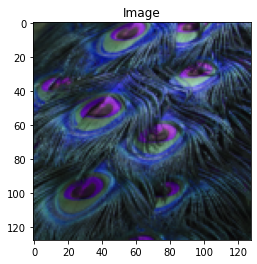

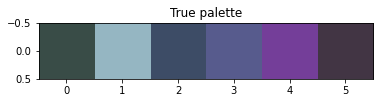

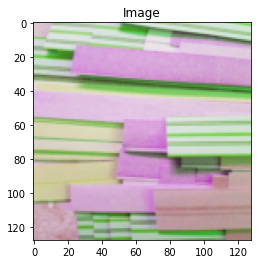

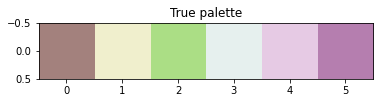

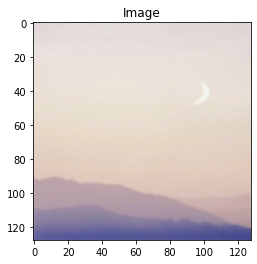

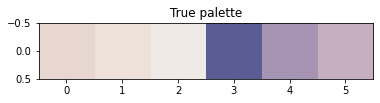

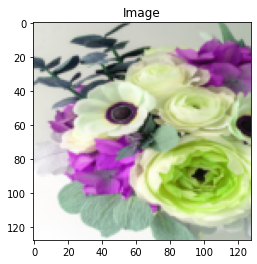

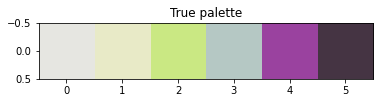

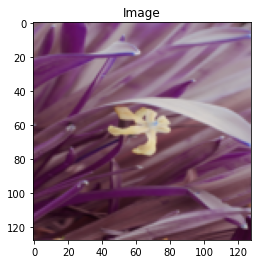

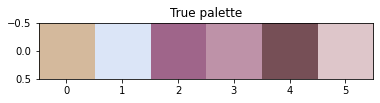

In [5]:
from matplotlib import pyplot as plt
import torch

i = 0
for x, y_true in iter(test_dataset):
    if i < 5:
        i += 1
    else:
        break

    plt.imshow(x.cpu().permute(1, 2, 0).numpy())
    plt.title("Image")
    plt.show()

    plt.imshow(y_true.cpu().permute(1, 2, 0).numpy())
    plt.title("True palette")
    plt.show()

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=16)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=16)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=16)

In [7]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from repalette.constants import MODELS_DIR
from repalette.models import PaletteExctractorNet

checkpoint_callback = ModelCheckpoint(
    filepath=MODELS_DIR,
    verbose=True,
    mode='min'
)

early_stop_callback = EarlyStopping(
   min_delta=0.00,
   patience=3,
   verbose=False,
   mode='min'
)

hparams = dict(dropout=0.2, learning_rate=1e-4)
model = PaletteExctractorNet(hparams)

trainer = Trainer(
    gpus=1, # user gpu!
    checkpoint_callback=checkpoint_callback,
    early_stop_callback=early_stop_callback,
)  

/home/dan/miniconda3/envs/repalette/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Checkpoint directory /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/ exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [10]:
trainer.fit(model, train_dataloader, val_dataloader)


  | Name    | Type    | Params
------------------------------------
0 | flatten | Flatten | 0     
1 | dropout | Dropout | 0     
2 | act     | ReLU    | 0     
3 | linear  | Linear  | 884 K 
4 | sigmoid | Sigmoid | 0     



Epoch 00023: val_checkpoint_on reached 0.03174 (best 0.03174), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=23.ckpt as top 1



Epoch 00024: val_checkpoint_on reached 0.03102 (best 0.03102), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=24.ckpt as top 1



Epoch 00025: val_checkpoint_on reached 0.03080 (best 0.03080), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=25.ckpt as top 1



Epoch 00026: val_checkpoint_on  was not in top 1



Epoch 00027: val_checkpoint_on reached 0.03049 (best 0.03049), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=27.ckpt as top 1



Epoch 00028: val_checkpoint_on  was not in top 1



Epoch 00029: val_checkpoint_on reached 0.03027 (best 0.03027), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=29.ckpt as top 1



Epoch 00030: val_checkpoint_on reached 0.03025 (best 0.03025), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=30.ckpt as top 1



Epoch 00031: val_checkpoint_on  was not in top 1



Epoch 00032: val_checkpoint_on  was not in top 1



Epoch 00033: val_checkpoint_on  was not in top 1



Epoch 00034: val_checkpoint_on reached 0.03013 (best 0.03013), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=34.ckpt as top 1



Epoch 00035: val_checkpoint_on  was not in top 1



Epoch 00036: val_checkpoint_on  was not in top 1



Epoch 00037: val_checkpoint_on  was not in top 1



Epoch 00038: val_checkpoint_on reached 0.02990 (best 0.02990), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=38.ckpt as top 1



Epoch 00039: val_checkpoint_on  was not in top 1



Epoch 00040: val_checkpoint_on  was not in top 1



Epoch 00041: val_checkpoint_on reached 0.02983 (best 0.02983), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=41.ckpt as top 1



Epoch 00042: val_checkpoint_on  was not in top 1



Epoch 00043: val_checkpoint_on reached 0.02976 (best 0.02976), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=43.ckpt as top 1



Epoch 00044: val_checkpoint_on reached 0.02973 (best 0.02973), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=44.ckpt as top 1



Epoch 00045: val_checkpoint_on  was not in top 1



Epoch 00046: val_checkpoint_on reached 0.02963 (best 0.02963), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=46.ckpt as top 1



Epoch 00047: val_checkpoint_on  was not in top 1



Epoch 00048: val_checkpoint_on  was not in top 1



Epoch 00049: val_checkpoint_on  was not in top 1



Epoch 00050: val_checkpoint_on  was not in top 1



Epoch 00051: val_checkpoint_on  was not in top 1



Epoch 00052: val_checkpoint_on reached 0.02934 (best 0.02934), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=52.ckpt as top 1



Epoch 00053: val_checkpoint_on  was not in top 1



Epoch 00054: val_checkpoint_on  was not in top 1



Epoch 00055: val_checkpoint_on  was not in top 1



Epoch 00056: val_checkpoint_on  was not in top 1



Epoch 00057: val_checkpoint_on reached 0.02917 (best 0.02917), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=57.ckpt as top 1



Epoch 00058: val_checkpoint_on  was not in top 1



Epoch 00059: val_checkpoint_on  was not in top 1



Epoch 00060: val_checkpoint_on  was not in top 1



Epoch 00061: val_checkpoint_on  was not in top 1



Epoch 00062: val_checkpoint_on  was not in top 1



Epoch 00063: val_checkpoint_on  was not in top 1



Epoch 00064: val_checkpoint_on  was not in top 1



Epoch 00065: val_checkpoint_on  was not in top 1



Epoch 00066: val_checkpoint_on  was not in top 1



Epoch 00067: val_checkpoint_on  was not in top 1



Epoch 00068: val_checkpoint_on  was not in top 1



Epoch 00069: val_checkpoint_on  was not in top 1



Epoch 00070: val_checkpoint_on  was not in top 1



Epoch 00071: val_checkpoint_on  was not in top 1



Epoch 00072: val_checkpoint_on  was not in top 1



Epoch 00073: val_checkpoint_on reached 0.02907 (best 0.02907), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=73.ckpt as top 1



Epoch 00074: val_checkpoint_on  was not in top 1



Epoch 00075: val_checkpoint_on reached 0.02906 (best 0.02906), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=75.ckpt as top 1



Epoch 00076: val_checkpoint_on reached 0.02874 (best 0.02874), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=76.ckpt as top 1



Epoch 00077: val_checkpoint_on  was not in top 1



Epoch 00078: val_checkpoint_on  was not in top 1



Epoch 00079: val_checkpoint_on  was not in top 1



Epoch 00080: val_checkpoint_on  was not in top 1



Epoch 00081: val_checkpoint_on  was not in top 1



Epoch 00082: val_checkpoint_on  was not in top 1



Epoch 00083: val_checkpoint_on  was not in top 1



Epoch 00084: val_checkpoint_on  was not in top 1



Epoch 00085: val_checkpoint_on  was not in top 1



Epoch 00086: val_checkpoint_on  was not in top 1



Epoch 00087: val_checkpoint_on  was not in top 1



Epoch 00088: val_checkpoint_on  was not in top 1



Epoch 00089: val_checkpoint_on  was not in top 1



Epoch 00090: val_checkpoint_on  was not in top 1



Epoch 00091: val_checkpoint_on  was not in top 1



Epoch 00092: val_checkpoint_on  was not in top 1



Epoch 00093: val_checkpoint_on  was not in top 1



Epoch 00094: val_checkpoint_on  was not in top 1



Epoch 00095: val_checkpoint_on  was not in top 1



Epoch 00096: val_checkpoint_on  was not in top 1



Epoch 00097: val_checkpoint_on  was not in top 1



Epoch 00098: val_checkpoint_on  was not in top 1



Epoch 00099: val_checkpoint_on reached 0.02852 (best 0.02852), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=99.ckpt as top 1



Epoch 00100: val_checkpoint_on reached 0.02835 (best 0.02835), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=100.ckpt as top 1



Epoch 00101: val_checkpoint_on  was not in top 1



Epoch 00102: val_checkpoint_on  was not in top 1



Epoch 00103: val_checkpoint_on  was not in top 1



Epoch 00104: val_checkpoint_on  was not in top 1



Epoch 00105: val_checkpoint_on  was not in top 1



Epoch 00106: val_checkpoint_on  was not in top 1



Epoch 00107: val_checkpoint_on  was not in top 1



Epoch 00108: val_checkpoint_on  was not in top 1



Epoch 00109: val_checkpoint_on  was not in top 1



Epoch 00110: val_checkpoint_on reached 0.02813 (best 0.02813), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=110.ckpt as top 1



Epoch 00111: val_checkpoint_on  was not in top 1



Epoch 00112: val_checkpoint_on reached 0.02810 (best 0.02810), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=112.ckpt as top 1



Epoch 00113: val_checkpoint_on  was not in top 1



Epoch 00114: val_checkpoint_on  was not in top 1



Epoch 00115: val_checkpoint_on  was not in top 1



Epoch 00116: val_checkpoint_on  was not in top 1



Epoch 00117: val_checkpoint_on  was not in top 1



Epoch 00118: val_checkpoint_on  was not in top 1



Epoch 00119: val_checkpoint_on  was not in top 1



Epoch 00120: val_checkpoint_on  was not in top 1



Epoch 00121: val_checkpoint_on reached 0.02791 (best 0.02791), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=121.ckpt as top 1



Epoch 00122: val_checkpoint_on reached 0.02785 (best 0.02785), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=122.ckpt as top 1



Epoch 00123: val_checkpoint_on  was not in top 1



Epoch 00124: val_checkpoint_on  was not in top 1



Epoch 00125: val_checkpoint_on  was not in top 1



Epoch 00126: val_checkpoint_on  was not in top 1



Epoch 00127: val_checkpoint_on  was not in top 1



Epoch 00128: val_checkpoint_on  was not in top 1



Epoch 00129: val_checkpoint_on reached 0.02779 (best 0.02779), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=129.ckpt as top 1



Epoch 00130: val_checkpoint_on  was not in top 1



Epoch 00131: val_checkpoint_on  was not in top 1



Epoch 00132: val_checkpoint_on  was not in top 1



Epoch 00133: val_checkpoint_on  was not in top 1



Epoch 00134: val_checkpoint_on  was not in top 1



Epoch 00135: val_checkpoint_on  was not in top 1



Epoch 00136: val_checkpoint_on  was not in top 1



Epoch 00137: val_checkpoint_on reached 0.02758 (best 0.02758), saving model to /home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=137.ckpt as top 1



Epoch 00138: val_checkpoint_on  was not in top 1



Epoch 00139: val_checkpoint_on  was not in top 1



Epoch 00140: val_checkpoint_on  was not in top 1



Epoch 00141: val_checkpoint_on  was not in top 1



Epoch 00142: val_checkpoint_on  was not in top 1



Epoch 00143: val_checkpoint_on  was not in top 1



Epoch 00144: val_checkpoint_on  was not in top 1



Epoch 00145: val_checkpoint_on  was not in top 1



Epoch 00146: val_checkpoint_on  was not in top 1



Epoch 00147: val_checkpoint_on  was not in top 1



Epoch 00148: val_checkpoint_on  was not in top 1


1

In [16]:
model.hparams["learning_rate"]

1.0000000000000002e-06

In [9]:
model.hparams["learning_rate"] /= 10

'checkpoint_callback_best_model_path'

In [8]:
best_model = PaletteExctractorNet.load_from_checkpoint(
    "/home/dan/Projects/repalette/repalette/models/pytorch_models_checkpoints/epoch=137.ckpt"
)

In [9]:
trainer.test(best_model, test_dataloader)

/home/dan/miniconda3/envs/repalette/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.025513295084238052}
--------------------------------------------------------------------------------



[{'test_loss': 0.025513295084238052}]

In [10]:
batch = next(iter(test_dataloader))

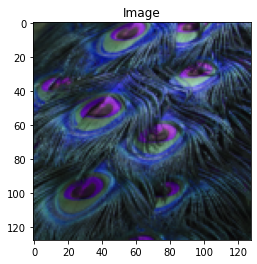

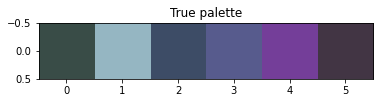

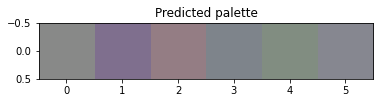

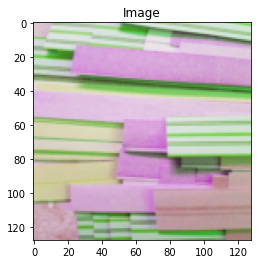

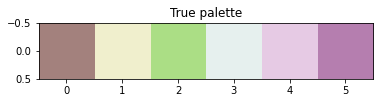

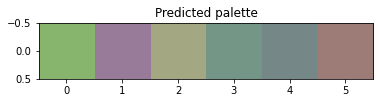

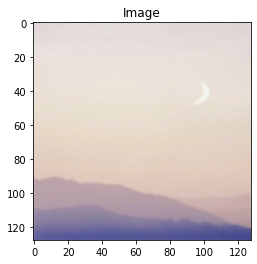

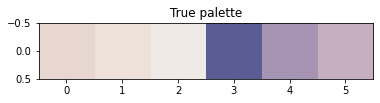

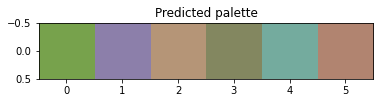

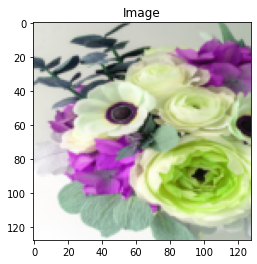

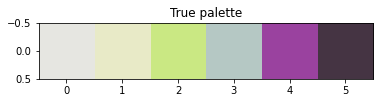

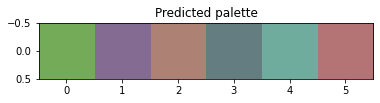

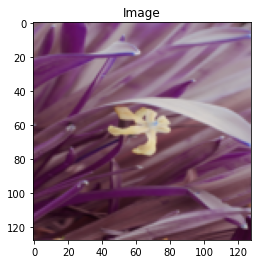

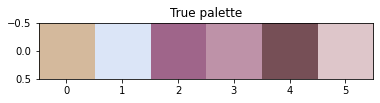

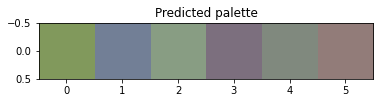

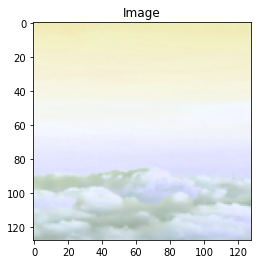

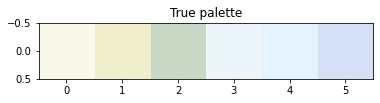

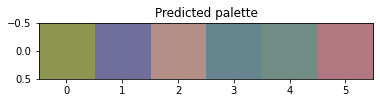

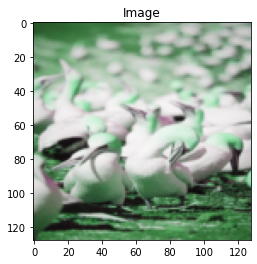

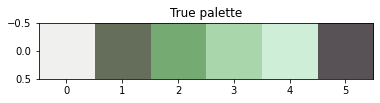

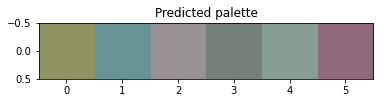

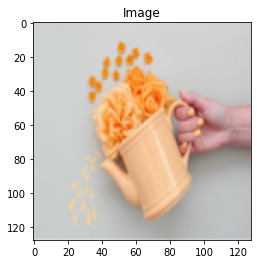

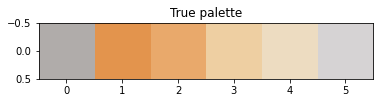

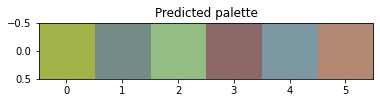

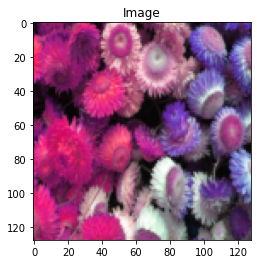

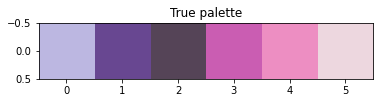

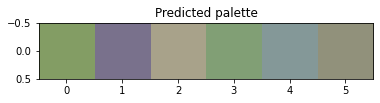

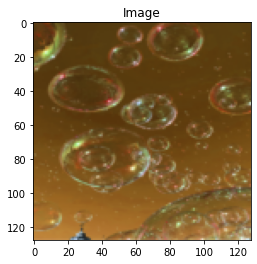

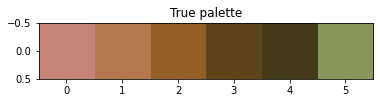

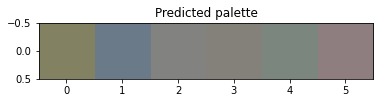

In [11]:
from matplotlib import pyplot as plt
import torch

best_model.eval()
i = 0
for x, y_true in zip(batch[0], batch[1]):
    if i < 10:
        i += 1
    else:
        break
    with torch.no_grad():
        y_pred = model(x.unsqueeze(0))

    plt.imshow(x.cpu().permute(1, 2, 0).numpy())
    plt.title("Image")
    plt.show()

    plt.imshow(y_true.cpu().permute(1, 2, 0).numpy())
    plt.title("True palette")
    plt.show()

    plt.imshow(y_pred.cpu().squeeze(0).permute(1, 2, 0).numpy())
    plt.title("Predicted palette")
    plt.show()

torch.Size([32, 3, 1, 6])

In [16]:
model(x.unsqueeze(0)).shape

torch.Size([1, 3, 1, 6])